# Imports

In [1]:
import torch
import pyro
from matplotlib import pyplot as plt

# Problem statement

A simple problem where we try to map a mixture of Gaussians

In [2]:
D = 2  # Visualization won't work if you change this

In [5]:
points_per_gaussian = []
N = 200
G = 2
for i in range(G):
    L = -0.5 + torch.rand((D, D))
    gaussian = pyro.distributions.MultivariateNormal(
        loc=5 * torch.rand((D,)),
        covariance_matrix=L @ L.T
    )

    points_per_gaussian.append(gaussian.sample((N,)))


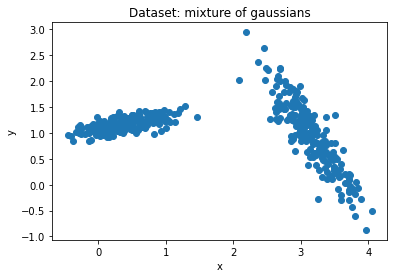

In [6]:
points = torch.cat(points_per_gaussian)
plt.scatter(
    points[:, 0],
    points[:, 1]
)
plt.title("Dataset: mixture of gaussians")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# NF construction

We start off with a simple normal distribution of the same dimensionality:

In [7]:
base_distribution = pyro.distributions.Normal(
    loc=torch.zeros((D,)),
    scale=1
)

We are going to stack a few affine autoregressive blocks (MAF architecture)

In [20]:
n_blocks = 3
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_autoregressive(
            input_dim=D,
            hidden_dims=[8, 8, 8]
        )
    )

We obtain a transformed distribution that can be used as any off-the-shelf distribution

In [21]:
transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=base_distribution,
    transforms=blocks
)

In [22]:
transformed_distribution.sample((2,))

tensor([[ 2.5152, -0.8085],
        [-1.9876,  0.5602]])

In [23]:
transformed_distribution.log_prob(torch.zeros((D,)))

tensor(-2.2726, grad_fn=<AddBackward0>)

# NF training

In [24]:
modules = torch.nn.ModuleList(blocks)
optimizer = torch.optim.Adam(modules.parameters())
n_epochs = 3000
epoch_visualization = 100

Epoch 100 / 3000 loss: 2.662986993789673


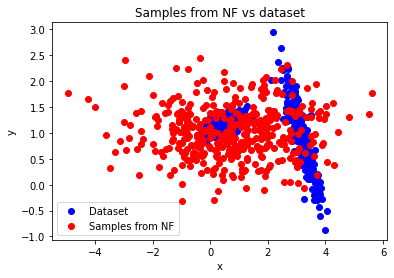

Epoch 200 / 3000 loss: 1.9438704252243042


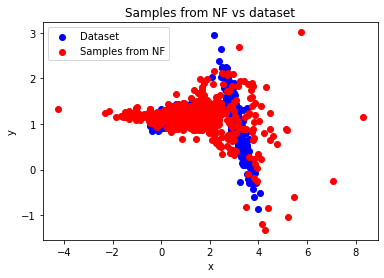

Epoch 300 / 3000 loss: 1.480387568473816


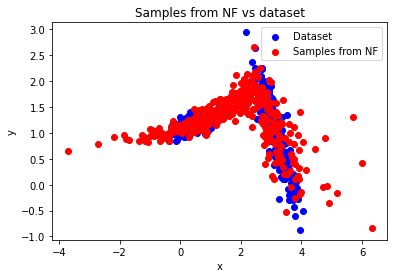

Epoch 400 / 3000 loss: 1.2439314126968384


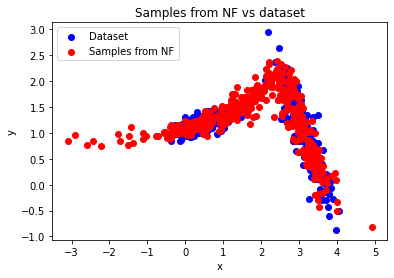

Epoch 500 / 3000 loss: 1.1806296110153198


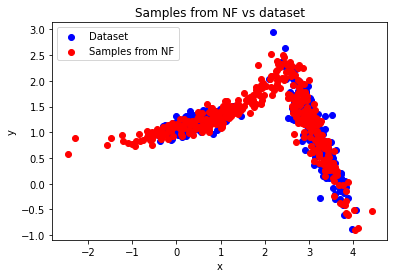

Epoch 600 / 3000 loss: 1.1573313474655151


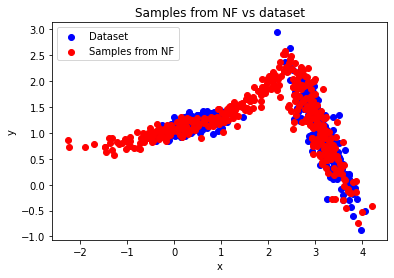

Epoch 700 / 3000 loss: 1.1383503675460815


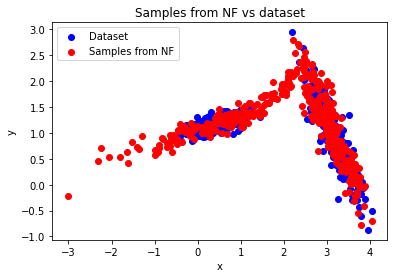

Epoch 800 / 3000 loss: 1.1202256679534912


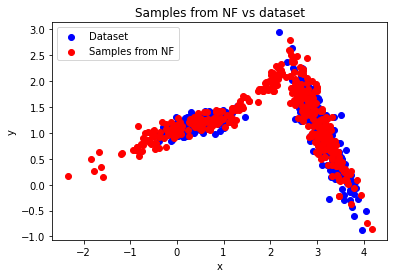

Epoch 900 / 3000 loss: 1.0954090356826782


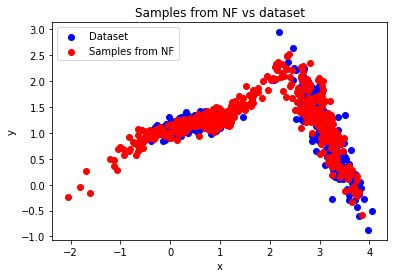

Epoch 1000 / 3000 loss: 1.0548901557922363


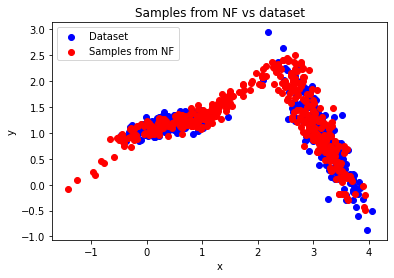

Epoch 1100 / 3000 loss: 0.9963409900665283


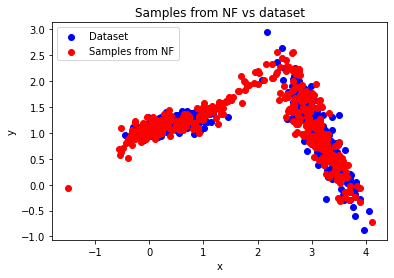

Epoch 1200 / 3000 loss: 0.9329767823219299


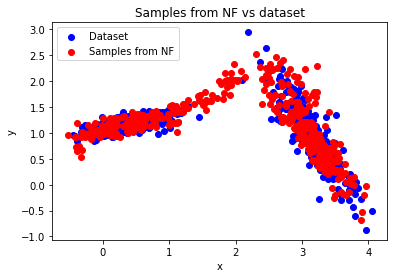

Epoch 1300 / 3000 loss: 0.9083731174468994


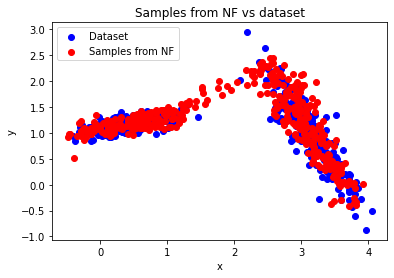

Epoch 1400 / 3000 loss: 0.897936224937439


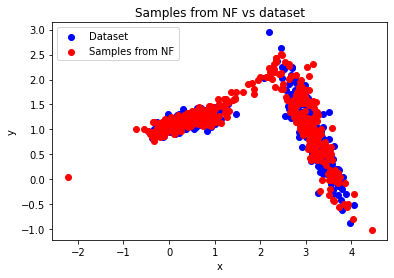

Epoch 1500 / 3000 loss: 0.8899602293968201


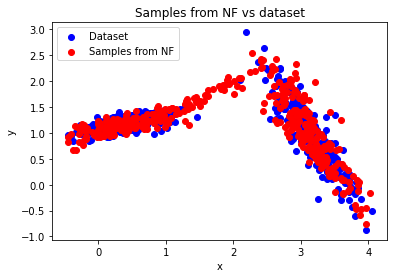

Epoch 1600 / 3000 loss: 0.8843877911567688


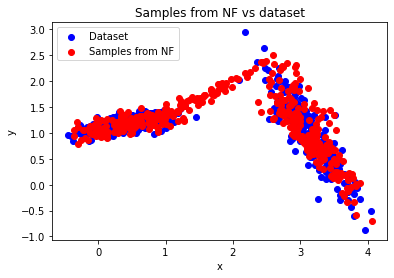

Epoch 1700 / 3000 loss: 0.8783496022224426


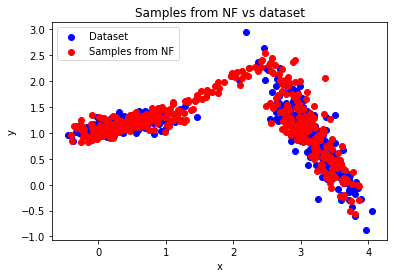

Epoch 1800 / 3000 loss: 0.8740331530570984


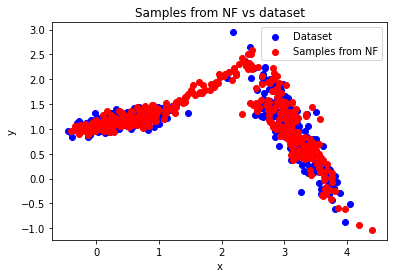

Epoch 1900 / 3000 loss: 0.869455873966217


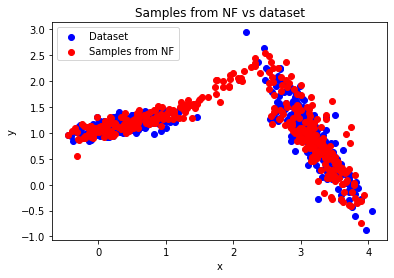

Epoch 2000 / 3000 loss: 0.8640356659889221


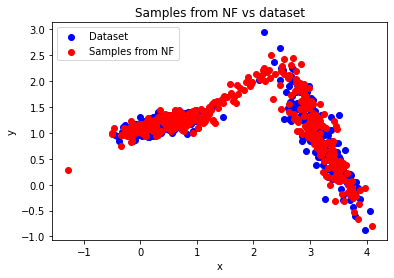

Epoch 2100 / 3000 loss: 0.8603919148445129


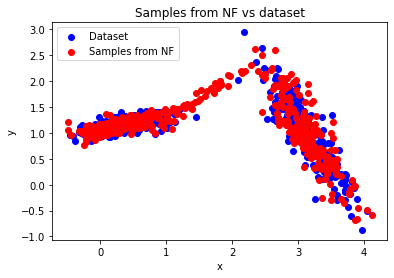

Epoch 2200 / 3000 loss: 0.8547775745391846


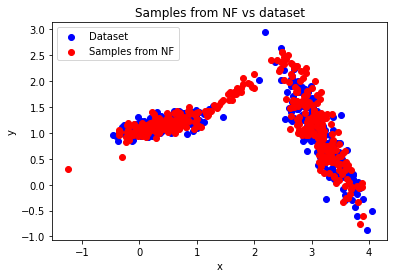

Epoch 2300 / 3000 loss: 0.8501666784286499


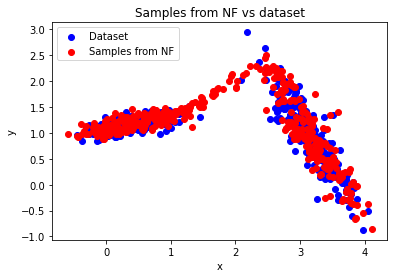

Epoch 2400 / 3000 loss: 0.8468658924102783


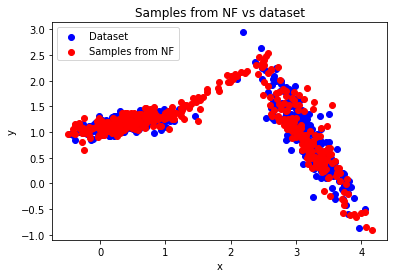

Epoch 2500 / 3000 loss: 0.8423810005187988


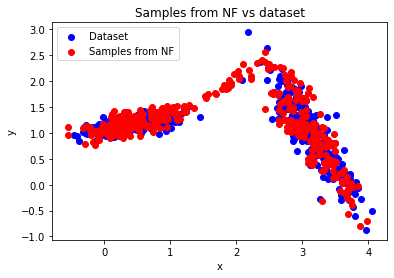

Epoch 2600 / 3000 loss: 0.8386547565460205


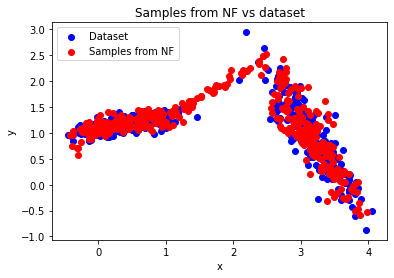

Epoch 2700 / 3000 loss: 0.8357799649238586


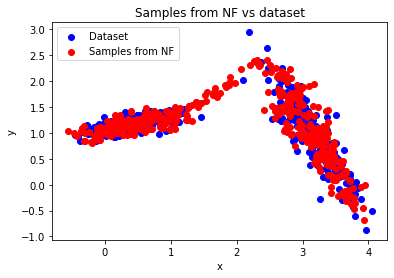

Epoch 2800 / 3000 loss: 0.8309634327888489


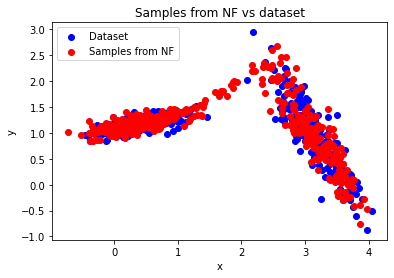

Epoch 2900 / 3000 loss: 0.828352153301239


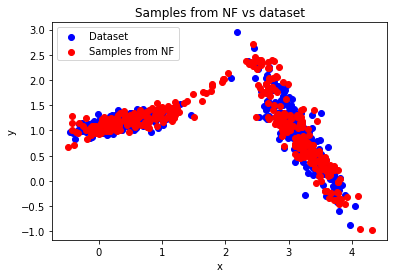

Epoch 3000 / 3000 loss: 0.8264389038085938


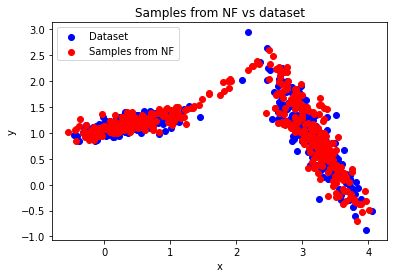

In [25]:
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    # batch gradient descent:
    loss = - transformed_distribution.log_prob(points).mean()
    loss.backward()
    optimizer.step()

    transformed_distribution.clear_cache()  # !! Important implementation detail

    if epoch % epoch_visualization == 0:
        samples = transformed_distribution.sample((2 * N,))
        print(f"Epoch {epoch} / {n_epochs} loss: {loss}")
        plt.scatter(
            points[:, 0],
            points[:, 1],
            color="blue"
        )
        plt.scatter(
            samples[:, 0],
            samples[:, 1],
            color="red"
        )
        plt.title("Samples from NF vs dataset")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(
            [
                "Dataset",
                "Samples from NF"
            ]
        )
        plt.show()